In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml
from sklearn import datasets

In [6]:
iris = datasets.load_iris()
X = iris.data  
y = iris.target


In [7]:
X = StandardScaler().fit_transform(X)


In [8]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(50, 4)
(50, 4)


In [9]:
indices=np.arange(25)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:25]
x_train=np.concatenate((np.array(x_neg[0:25])[indices],x_pos)).reshape(-1,4)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [10]:
x_test = x_neg[25:50].reshape(-1,4)
y_test = y_neg[25:50].reshape(-1,1)

# Projection model

In [11]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [12]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [14]:
num_of_iterations = 20 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,60,60,50,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(50, 4)
Size: 60 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.051366 



Size: 120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.030589 



Size: 180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.026862 



Size: 240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.030944 



Size: 300 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.032091 



Size: 360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.033176 



Size: 420 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.059233 



Size: 480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.039686 



Size: 540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.041485 



Size: 600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.045005 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047462 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056724 



S

Size: 360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.054065 



Size: 420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076390 



Size: 480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122198 



Size: 540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133290 



Size: 600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080690 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076908 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183306 



Size: 780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090808 



Size: 840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084134 



Size: 900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116313 



Size: 960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091655 



Size: 1020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086800 



Size: 1080 Bits - FPR: 0.000000 - Time 

Size: 600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052094 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049055 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.063571 



Size: 780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050991 



Size: 840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056657 



Size: 900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055472 



Size: 960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.057830 



Size: 1020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.065673 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069237 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074974 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.071828 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084447 



Size: 1320 Bits - FPR: 0.000000 - T

Size: 780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.059927 



Size: 840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055577 



Size: 900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069004 



Size: 960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062683 



Size: 1020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.064511 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.064823 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.067593 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.068526 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079933 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078394 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087634 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082399 



Size: 1500 Bits - FPR: 0.000000 

Size: 960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.066891 



Size: 1020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062859 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.065142 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.068189 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072128 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072362 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076392 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084746 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084249 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081456 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.094935 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086800 



Size: 1680 Bits - FPR: 0.0000

Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.073872 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.077253 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.077001 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081925 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078391 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082584 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087410 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088605 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095983 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102325 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.094491 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096240 



Size: 1920 Bits - FPR: 0.000

Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080817 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078741 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079590 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087768 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085995 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095035 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091640 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.094009 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093240 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098764 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099038 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100890 



Size: 2040 Bits - FPR: 0.000

Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079154 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.077930 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081774 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105310 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101606 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111508 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126483 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116815 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095875 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.097489 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103420 



Size: 2040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104009 



Size: 2100 Bits - FPR: 0.000

Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090062 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087757 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095441 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119678 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137140 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116124 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101168 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124582 



Size: 2040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109924 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114577 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132217 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131896 



Size: 2280 Bits - FPR: 0.000

Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096704 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.094019 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103669 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098684 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102481 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112784 



Size: 2040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107827 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112455 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108133 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116300 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118886 



Size: 2340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126252 



Size: 2400 Bits - FPR: 0.000

In [30]:
print(fpr_values)

[0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [22]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += ["%.6f"% temp]
print(average_fprs)

['0.016000', '0.010000', '0.024000', '0.010000', '0.008000', '0.006000', '0.006000', '0.000000', '0.000000', '0.000000', '0.002000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']


In [23]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += ["%.6f"%temp]
print(average_times)

['0.032526', '0.032875', '0.032850', '0.033967', '0.036730', '0.037838', '0.046557', '0.048764', '0.052404', '0.051105', '0.055924', '0.062669', '0.060958', '0.060939', '0.066789', '0.070310', '0.071587', '0.078754', '0.080470', '0.076092', '0.083141', '0.082081', '0.086357', '0.089773', '0.089859', '0.095555', '0.097421', '0.099130', '0.105640', '0.112282', '0.105594', '0.109428', '0.113075', '0.116927', '0.118495', '0.123047', '0.121754', '0.135540', '0.144726', '0.151728', '0.138488', '0.142168', '0.138312', '0.141775', '0.146257', '0.163944', '0.163608', '0.156743', '0.156574', '0.159534']


# Normal Bloom Filter Values

In [24]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [31]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
   # y_ideal+=[float(ideal_fpr(x,n))]
    y_ideal+=["%.4f" % ideal_fpr(x,n)]

print(len(y_ideal))
print(y_ideal)

1000
['0.5684', '0.3419', '0.1824', '0.1008', '0.0563', '0.0331', '0.0182', '0.0101', '0.0056', '0.0032', '0.0018', '0.0010', '0.0006', '0.0003', '0.0002', '0.0001', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.5684', '0.3419', '0.1824', '0.1008', '0.0563', '0.0331', '0.0182', '0.0101', '0.0056', '0.0032', '0.0018', '0.0010', '0.0006', '0.0003', '0.0002', '0.0001', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0

# FPR Comparison between Projection Model and Normal Bloom Filter

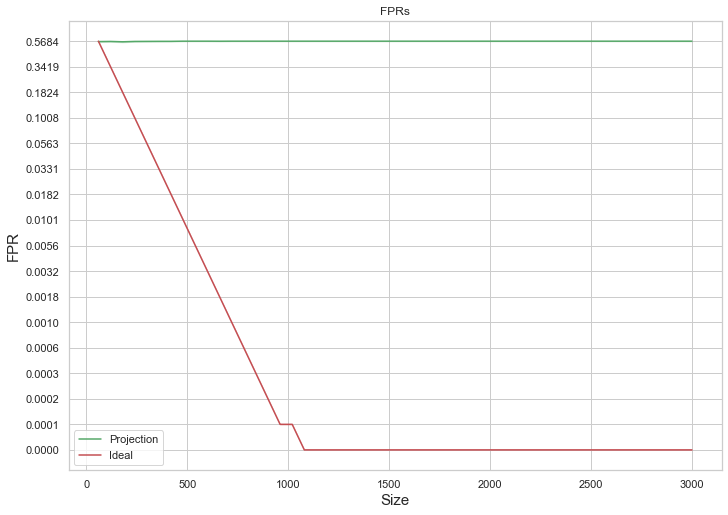

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [27]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

1000


In [28]:
average_times = num_of_iterations*average_times
print(len(average_times))

1000


In [29]:
print(average_fprs)

['0.016000', '0.010000', '0.024000', '0.010000', '0.008000', '0.006000', '0.006000', '0.000000', '0.000000', '0.000000', '0.002000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.016000', '0.010000', '0.024000', '0.010000', '0.008000', '0.006000', '0.006000', '0.000000', '0.000000', '0.000000', '0.002000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.

In [47]:
print(average_fprs)

[0.008, 0.0, 0.018, 0.019999999999999997, 0.008, 0.018, 0.014000000000000002, 0.012, 0.019999999999999997, 0.008, 0.018, 0.018, 0.01, 0.016, 0.006, 0.01, 0.023999999999999997, 0.008, 0.022, 0.012, 0.016, 0.012, 0.014000000000000002, 0.012, 0.014000000000000002, 0.014000000000000002, 0.004, 0.012, 0.008, 0.019999999999999997, 0.006, 0.013999999999999999, 0.014000000000000002, 0.02, 0.006, 0.004, 0.01, 0.004, 0.004, 0.006, 0.008, 0.002, 0.002, 0.0, 0.0, 0.004, 0.002, 0.002, 0.004, 0.01, 0.004, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.002, 0.004, 0.004, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

In [ ]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Iris_rerun_epochs_100.csv')